<a href="https://colab.research.google.com/github/abhik-99/MFSGC/blob/master/(Train)_5and10_fold_Cross_Validation_on_MFSGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-filtering Supervised Gene Clustering.

**(Train) (Using 5-fold Cross Validation) (Using Representational Genes generated from top 800 Genes)**
##Current Status:-
Completed

**Please Run the Dataset Splitter before running this Notebook.** Provide the 
*DATASET_train.csv* generated from the Dataset Splitter Notebook as the 
input to this Notebook at cell 4 as an upload.\
\
*If you already have Gene Representatives from a previous iteration, you can load them and use them here. Loading can be done using the last two cells of this notebook.

In [2]:
!pip install -U -q PyDrive
!pip install skfeature-chappers
!pip install scikit-plot

  Created wheel for skfeature-chappers: filename=skfeature_chappers-1.0.3-py2.py3-none-any.whl size=59510 sha256=50b4c39c2f6d28d9d90309f9baf0b5cee28642693581ee31b863441758b76031
  Stored in directory: /root/.cache/pip/wheels/ac/61/bf/1b3a8c232a0072409508c2ec4c12f316e95681ae72ba7315d2
Successfully built skfeature-chappers


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

import json

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

from scipy.sparse import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating Filter Methods for Scoring and filtering top rated genes
The Filter Methods chosen for evaluation are:-

1. Mutual Information.
2. ReliefF.
3. Chi Sq.
4. Fisher Score.
5. Signal To Noise Ratio (adapted for multi-class datasets).
6. T-Test.
7. Pearson Corelation Coefficient.

In [5]:
#construction of ReliefF function

"""
Given a dataset, number of random instances to pick form the dataset and
number of features to consider in each iteration (k), the function returns the weigths of the attributes
of the dataset.
These weigths can then be used as the final results out of the ReliefF algorithm

Paper-

Marko Robnik-ˇSikonja and Igor Kononenko. Theoretical and empirical analysis of relieff
and rrelieff. Machine learning, 53(1-2):23–69, 2003.

"""

def hit_miss_calculator(target,instance,k = 10, hit = True, c = None, ):
    m=len(target)
    upper,lower=instance-1,instance+1
    hits=[]
    hit_flag=False
    #finds k nearest hits
    while(not hit_flag):
      #print(upper,lower)
      if(len(hits)>=k):
        hit_flag = True
        break
      if upper < 0 and lower > m:
        hit_flag = True
        break
      if(upper>=0):
        if((target[upper]==target[instance]) and hit):
          hits.append(upper)
        elif((target[upper]!=target[instance]) and (not hit) and target[upper]==c):
          hits.append(upper)
        upper-=1          
      if(lower<m):
        if((target[lower]==target[instance]) and hit):
          hits.append(lower)
        elif((target[lower]!=target[instance]) and (not hit) and target[lower]==c):
          hits.append(lower)
        lower+=1
    hits.sort()
    return hits


def reliefF(feature,target,k=10,repetitions=10, seed = 0):
  np.random.seed(seed)
  if len(feature.shape)>1:
    m,n=feature.shape
  else:
    m=len(feature)
    n=1
  #print(m,n)
  observations=list(range(m))
  classes=np.unique(target)
  weights=np.zeros(n)
  d=(np.max(feature,axis=0)-np.min(feature,axis=0))*m*k

  for i in range(repetitions):
    instance=np.random.choice(observations,1)[0]
    #print("Iteration",i)
    #print(instance)
    hits=hit_miss_calculator(target,instance,k)
    hit_class_prob=len(np.where(target==target[instance])[0])/m
    #print("\nHit Probability -",hit_class_prob)
    #print("Repetition",i,"Class",target[instance],"Hits -",hits)

    miss={}
    miss_class_prob={}

    for each_class in classes:
      if(each_class != target[instance]):
        miss[each_class]=hit_miss_calculator(target,instance,k,False,each_class)
        class_prob=len(np.where(target==each_class)[0])/m
        #print(each_class,class_prob)
        miss_class_prob[each_class]=hit_class_prob/(1 - (class_prob))

    #print("Repetition",i,"Miss-",miss,"Miss Class Probability -",miss_class_prob)
    
    for hit in hits:
      if len(feature.shape)>1:
        weights-=np.subtract(feature.iloc[instance,:],feature.iloc[hit,:])/d
      else:
        weights-=np.subtract(feature.iloc[instance],feature.iloc[hit])/d
    for each_class in miss:
      for each_miss in miss[each_class]:
        if len(feature.shape)>1:
          weights+=(np.subtract(feature.iloc[instance,:],feature.iloc[each_miss,:])/d)*miss_class_prob[each_class]
        else:
          weights+=(np.subtract(feature.iloc[instance],feature.iloc[each_miss])/d)*miss_class_prob[each_class]
    
    
  return weights.tolist()

In [6]:
#This function discretizes the given features into 3 categories
def discretize_feature(feature):
  
  mean=np.mean(feature)
  std=np.std(feature)
  discretized=np.copy(feature)
  
  discretized[np.where(feature<(mean+std/2)) ,]=2#within 1/2 std div
  discretized[np.where(feature>(mean-std/2)),]=2#within 1/2 std div
  
  discretized[np.where(feature>(mean+std/2)),]=0#greater than half
  discretized[np.where(feature<(mean-std/2)),]=1#less than half
  
  return discretized

def Xfreq(x):
  xL={}
  for e in x:
    if e not in xL:
      xL[e]=0
    else:
      xL[e]+=1
  for e in xL:
    xL[e]/=len(x)
  return xL

def XYfreq(x,y):
  freq={}
  
  rX=np.unique(x)
  rY=np.unique(y)
      
  for e in rX:
    for f in rY:
      freq[(e,f)]=round(len(np.where(y[np.where(x==e)[0]]==f)[0])/len(x),4)
       
  return freq

def mutual_info(x,y):

  xFreq=Xfreq(x)
  yFreq=Xfreq(y)
  joint=XYfreq(x,y)
  
  Xentropy=0
  for e in xFreq:
    if xFreq[e]!=0:
      Xentropy-=xFreq[e]*np.log2(xFreq[e])
      
  Yentropy=0
  for e in yFreq:
    if yFreq[e]!=0:
      Yentropy-=yFreq[e]*np.log2(yFreq[e])
      
  jentropy=0
  for e in xFreq:
    for f in yFreq:
      if joint[(e,f)]!=0:
        jentropy-=joint[(e,f)]*np.log2(joint[(e,f)])
  
  return (Xentropy+Yentropy-jentropy)

def mutual_info_wrapper(features,target):

  mi=np.array([])
  for x in features:
    # print(x)
    discrete=discretize_feature(features[x])
    mi=np.append(mi,mutual_info(discrete,target))
  return np.array(mi)

In [7]:
"""
This cell is used for defining the method for calculating the t-scores
"""

def t_test(df,target):
  """
  Input:
  df= Dataframe of features (n_samples,n_features)
  target= Pandas Series/1D Numpy Array containing the class labels (n_samples)
  
  Output:
  scores= Descendingly Sorted array of features based on t-test 
  """
  import numpy as np
  from scipy.stats import ttest_ind
  scores=ttest_ind(df[:][target==0],df[:][target==1])[0] #Storing just the t-test scores and discarding the p-values from the result.
  
  # scores=np.argsort(scores,0)
  return [scores] if type(scores) != np.ndarray else scores

  

In [8]:
from scipy.sparse import *
def fisher_score(X, y):
    import numpy as np
    
    from skfeature.utility.construct_W import construct_W
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels

    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


In [9]:

#Pearson corelation
def pearson_corr(feature,targetClass):
  import numpy as np
  coef=[np.abs(np.corrcoef(feature[i].values,targetClass)[0,1]) for i in feature.columns]
  # range(feature.shape[1])
  coef=[0 if np.isnan(i) else i for i in coef]
  return coef


In [10]:
#gini_index 

In [11]:
#signal to noise ratio
#using weighted one-vs-all strategy for multi-class data
def signaltonoise(feature, target, axis = 0, ddof = 0):
  import numpy as np
  classes = np.unique(target)
  if len(feature.shape)<2:
    feature = feature.reshape(-1,1)
  row, _ = feature.shape
  if len(classes) <= 2:
    m = None
    std = 0
    for each in classes:
      idx = np.where(target == each)[0]
      #convinient way of doing m1-m2
      if m is None:
        m = feature.iloc[idx, :].mean(axis)
      else:
        m -= feature.iloc[idx, :].mean(axis)

      #sd1+sd2
      std += feature.iloc[idx, :].std(axis = axis, ddof = ddof)

    return np.asanyarray(m/std)

  else:
    snr_scores = [] #for storing the weighted scores
    #using the one vs all strategy for each class with
    for each in classes:
      idx = np.where(target == each)[0]
      idxn = np.where(target != each)[0]
      m = feature.iloc[idx, :].mean(axis) - feature.iloc[idxn, :].mean(axis)
      std = feature.iloc[idx, :].std(axis = axis, ddof = ddof) + feature.iloc[idxn, :].std(axis = axis, ddof = ddof) 
      snr_scores.append((m/std) * len(idx)/row) #weighted snr

    return np.asanyarray(snr_scores).sum(axis = axis)

In [12]:
#intentionally left blank!

In [13]:
def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

## Loading the Dataset

In [55]:
files.upload()

Saving Lung_p800_q5tt_cluster.json to Lung_p800_q5tt_cluster.json
Saving Lung_p800_q5snr_cluster.json to Lung_p800_q5snr_cluster.json
Saving Lung_p800_q5relief_cluster.json to Lung_p800_q5relief_cluster.json
Saving Lung_p800_q5pc_cluster.json to Lung_p800_q5pc_cluster.json
Saving Lung_p800_q5mi_cluster.json to Lung_p800_q5mi_cluster.json
Saving Lung_p800_q5fs_cluster.json to Lung_p800_q5fs_cluster.json
Saving Lung_p800_q5chi_cluster.json to Lung_p800_q5chi_cluster.json
Saving Lung_p800_q5Representative_Genes_7.csv to Lung_p800_q5Representative_Genes_7.csv
Saving Lung_p800_q5Representative_Genes_6.csv to Lung_p800_q5Representative_Genes_6.csv
Saving Lung_p800_q5Representative_Genes_5.csv to Lung_p800_q5Representative_Genes_5.csv
Saving Lung_p800_q5Representative_Genes_4.csv to Lung_p800_q5Representative_Genes_4.csv
Saving Lung_p800_q5Representative_Genes_3.csv to Lung_p800_q5Representative_Genes_3.csv
Saving Lung_p800_q5Representative_Genes_2.csv to Lung_p800_q5Representative_Genes_2.cs

{'Lung_p800_q5Representative_Genes_1.csv': b'3333,6570,3332,540,8369,12307,1430,6184,5355,8842,11257,3912,9311,3505,4118,7079,8748,1300,11302,3508,3277,4896,907,409,1947,5936,11128,4788,6583,310,4707,11971,4235,1633,771\n4541.800010000001,7632.899975,2196.600017,6637.899901000001,4353.699967,20094.90008,16678.900008999994,-651.7999940000001,7339.999984000002,-17404.899958,-156.50000900000003,-602.0000479999998,-3387.099913,-20933.699733999998,-20678.800275999998,-1651.0000210000003,4144.900040000001,-3754.399982000001,6882.799666000001,-8263.400274000001,-9303.499661999998,-32.300010999999955,1190.300003,1901.1999399999997,9366.899956,13087.900198,-1.7999839999999665,-2470.3000389999997,7776.900087999999,27023.599614,305.9,-673.0000050000001,-1456.199988,18.2,124.0\n4482.1999670000005,6728.600069,2098.5000779999996,5256.699938,5589.700018000001,9275.900052000003,8816.699901,-1724.000031,6774.4999480000015,-17827.799709000003,-1345.4000549999998,-4015.1000039999994,-2618.899951999999,-9

In [56]:
#DATASET is the name of the dataset being used.
DATASET="Lung"

#NEIGHBOURS determines neighbours arg for ReliefF
#for any dataset which contains any class sample 
# <10, make it less than 10. Eg of such dataset - SRBCT
NEIGHBOURS = 2 

#p is the number of top genes taken after sorting the filter scores
p = 800

#q is the number of top augmented genes chosen from each filter after running 
#SGC
q = 5

In [57]:
data_df=pd.read_csv("%s.txt"%(DATASET),sep="\t", index_col=None, header=None)
print(data_df.shape)
target=data_df.iloc[:,-1]
feature=pd.DataFrame(data_df.iloc[:,:-1].values,dtype='float')
m,n=feature.shape
print(m,n)
print(feature.head())
print("Number of classes - ")
classes = np.unique(target)
for x in classes:
  print("Class -",x,"Number of Samples -", len(np.where(target == x)[0]))

feature_norm=pd.DataFrame(MinMaxScaler().fit_transform(feature))

count_genes = dict(zip(map(int,feature.columns.tolist()), np.zeros(data_df.shape[1], dtype= np.int16)))

(180, 12534)
180 12533
        0          1      2      ...       12530  12531       12532
0  188.500000  82.000000  -10.1  ...   28.900000   -6.6   40.599998
1  284.100006  35.599998  -19.6  ...  257.000000   25.1  -79.599998
2  204.500000  20.400000    9.4  ...    4.500000   11.2  -43.299999
3  213.100006  98.300003   31.4  ...   62.200001    8.3 -172.500000
4  487.299988  27.200001   11.5  ...   22.299999  -14.0  -94.699997

[5 rows x 12533 columns]
Number of classes - 
Class - 0 Number of Samples - 150
Class - 1 Number of Samples - 30


In [58]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12494,12495,12496,12497,12498,12499,12500,12501,12502,12503,12504,12505,12506,12507,12508,12509,12510,12511,12512,12513,12514,12515,12516,12517,12518,12519,12520,12521,12522,12523,12524,12525,12526,12527,12528,12529,12530,12531,12532,12533
0,188.500000,82.000000,-10.1,30.500000,-6.600000,877.099976,71.000000,309.899994,2347.199951,1017.599976,133.100006,-20.000000,270.600006,-1.100000,14.800000,133.899994,19.299999,3.700000,37.400002,-41.299999,52.299999,5.600000,477.399994,72.599998,-29.500000,-58.099998,-31.900000,27.799999,-62.900002,5.0,25.100000,-14.600000,32.700001,285.399994,21.600000,51.500000,8.000000,371.399994,635.000000,2.800000,...,196.899994,-44.700001,373.200012,-4.600000,-7.8,10.000000,94.800003,-14.3,55.000000,98.699997,56.099998,135.500000,1364.400024,-16.200001,361.200012,-9.700000,3.2,11.100000,72.599998,-24.700001,-5.500000,53.500000,-42.900002,32.700001,13.0,-86.099998,22.500000,15.600000,25.1,47.400002,14.500000,-32.299999,24.0,78.500000,24.400000,52.599998,28.900000,-6.6,40.599998,1
1,284.100006,35.599998,-19.6,-111.199997,-25.000000,993.400024,11.300000,594.099976,485.399994,843.900024,234.300003,4.800000,16.200001,1.700000,16.799999,60.700001,-161.199997,30.200001,28.900000,1.100000,132.500000,-9.200000,438.000000,-12.500000,3.600000,-57.099998,-26.400000,48.200001,27.700001,-14.8,21.900000,11.700000,18.700001,447.200012,26.100000,146.800003,33.900002,214.500000,184.300003,100.699997,...,121.699997,-28.799999,487.899994,-9.200000,28.6,25.000000,174.100006,-5.8,42.500000,96.500000,76.300003,124.099998,1081.599976,-13.300000,593.900024,-49.400002,7.1,64.599998,628.200012,-31.400000,-1.600000,46.200001,4.900000,51.799999,-13.7,-73.699997,40.200001,47.000000,9.8,36.299999,13.200000,59.000000,1.8,49.299999,1.500000,52.200001,257.000000,25.1,-79.599998,1
2,204.500000,20.400000,9.4,-99.500000,-10.100000,273.899994,22.799999,713.299988,250.000000,1212.199951,195.899994,7.600000,294.299988,-1.600000,13.000000,49.900002,-89.800003,-5.800000,32.500000,7.100000,83.300003,6.600000,530.200012,-6.000000,11.700000,3.600000,-19.600000,16.299999,5.300000,-25.0,12.800000,-1.600000,6.000000,363.399994,44.000000,138.000000,7.300000,118.599998,195.000000,16.600000,...,312.299988,-19.600000,170.300003,-2.500000,-1.1,17.700001,64.199997,10.2,34.500000,77.599998,125.000000,158.000000,983.900024,-18.299999,41.900002,-39.200001,11.2,49.099998,334.399994,-5.300000,-0.900000,173.199997,39.000000,42.900002,-2.5,-21.200001,53.900002,27.299999,16.4,59.599998,18.900000,18.700001,28.5,193.300003,5.400000,41.700001,4.500000,11.2,-43.299999,1
3,213.100006,98.300003,31.4,46.099998,75.000000,1568.599976,17.799999,769.200012,4540.299805,947.599976,259.100006,-35.099998,73.099998,-20.000000,-18.299999,7.300000,-60.799999,34.700001,-39.200001,-53.900002,194.600006,-42.099998,325.799988,38.000000,-50.099998,-239.500000,45.200001,4.600000,89.500000,13.0,152.800003,72.699997,44.900002,305.899994,32.700001,118.500000,19.299999,256.899994,344.100006,-12.100000,...,251.399994,7.800000,380.200012,-7.100000,10.4,50.799999,199.600006,-26.0,169.500000,190.000000,-3.000000,84.000000,3798.600098,-14.000000,537.099976,-108.900002,-8.0,34.500000,587.900024,-50.599998,-10.100000,30.400000,-45.500000,88.900002,-18.5,-29.299999,60.299999,119.099998,29.4,5.700000,14.700000,68.900002,25.5,40.900002,-38.200001,27.700001,62.200001,8.3,-172.500000,1
4,487.299988,27.200001,11.5,212.000000,-121.199997,709.200012,-84.300003,461.000000,7201.600098,457.899994,238.600006,-2.700000,52.299999,58.599998,20.799999,72.300003,94.599998,-2.000000,-48.700001,-23.000000,87.900002,-95.199997,441.299988,-35.099998,-53.200001,-150.899994,124.099998,39.500000,99.500000,-42.0,252.100006,-13.400000,1.000000,229.300003,-5.200000,46.200001,159.899994,480.700012,438.899994,6.900000,...,234.699997,-24.299999,518.400024,45.700001,47.0,12.100000,181.800003,-44.0,74.099998,137.

In [59]:
#utility function
def plot_feature(feature, target, c = ['r', 'b', 'g', 'y']):
  import matplotlib.pyplot as plt
  from matplotlib import style
  import numpy as np
  style.use('ggplot')
  for idx, each in enumerate(np.unique(target)):
    y = feature[np.where(target == each)[0]]
    x = len(y)
    plt.scatter(range(1, x+1), y, color = c[idx])
    plt.plot(range(1, x+1), y, color = c[idx])

In [60]:
def plot_roc_curve(fpr, tpr):
  import matplotlib.pyplot as plt
  from sklearn.metrics import auc
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

In [61]:
print(len(count_genes))

12533


In [62]:
"""
Loading the Cluster JSON files from memory
"""

with open('%s_p%s_q%smi_cluster.json'%(DATASET, p, q), 'r') as fp:
  mi_cluster=json.load(fp)

with open('%s_p%s_q%srelief_cluster.json'%(DATASET, p, q), 'r') as fp:
  chi_cluster=json.load(fp)


with open('%s_p%s_q%schi_cluster.json'%(DATASET, p, q), 'r') as fp:
  relief_cluster=json.load(fp)

with open('%s_p%s_q%spc_cluster.json'%(DATASET, p, q), 'r') as fp:
  pc_cluster=json.load(fp)

with open('%s_p%s_q%sfs_cluster.json'%(DATASET, p, q), 'r') as fp:
  fs_cluster=json.load(fp)

with open('%s_p%s_q%stt_cluster.json'%(DATASET, p, q), 'r') as fp:
  tt_cluster=json.load(fp)

with open('%s_p%s_q%ssnr_cluster.json'%(DATASET, p, q), 'r') as fp:
  snr_cluster=json.load(fp)

In [63]:
"""
Loading Representative Genes from Memory
"""
gene_repre_1 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_1.csv"%(DATASET, p, q),index_col = None)
gene_repre_2 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_2.csv"%(DATASET, p, q),index_col = None)
gene_repre_3 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_3.csv"%(DATASET, p, q),index_col = None)
gene_repre_4 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_4.csv"%(DATASET, p, q),index_col = None)
gene_repre_5 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_5.csv"%(DATASET, p, q),index_col = None)
gene_repre_6 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_6.csv"%(DATASET, p, q),index_col = None)
gene_repre_7 = pd.read_csv("%s_p%s_q%sRepresentative_Genes_7.csv"%(DATASET, p, q),index_col = None)

In [64]:
#Can Skip this cell
print(gene_repre_1.shape)
print(gene_repre_2.shape)
print(gene_repre_3.shape)
print(gene_repre_4.shape)
print(gene_repre_5.head())
print(gene_repre_6.head())
print(gene_repre_7.head())

(180, 35)
(180, 11)
(180, 20)
(180, 8)
           3333          3843  ...          2330          5936
0  18207.399890  29955.899996  ...  25267.800050  16651.000244
1  18679.900131  31833.999765  ...  10017.600036   5022.900147
2  18590.299976  31397.500178  ...   7791.299897   8229.399994
3  18295.500289  32412.100251  ...  39370.700318  41171.999633
4  18997.100106  32740.799826  ...  36178.300782  30283.400391

[5 rows x 8 columns]
          8536          5300  ...         3278         3277
0  9510.299942  13288.699984  ...  2965.500046  2204.100098
1  7716.999951  10673.999988  ...  3070.899952  3567.000000
2  9400.399944  13059.099926  ...   224.800007   191.100006
3  7937.700050   8701.000032  ...  1621.499970  1397.500000
4  8412.400015   9457.099952  ...  6248.000000  5926.399902

[5 rows x 7 columns]
         12113          6138  ...         3277        4118
0  5417.299974  12920.699952  ...  2204.100098  -44.699997
1  5326.099972  13029.899961  ...  3567.000000   -5.899994
2 

In [65]:
print("Number of MI Clusters formed -",len(mi_cluster))
print("Number of ReliefF Clusters formed -",len(relief_cluster))
print("Number of ChiSq. Clusters formed -",len(chi_cluster))
print("Number of Pearson Clusters formed -",len(pc_cluster))
print("Number of Fisher Score Clusters formed -",len(fs_cluster))
print("Number of T-Test Clusters formed -",len(tt_cluster))
print("Number of SNR Clusters formed -", len(snr_cluster))

Number of MI Clusters formed - 35
Number of ReliefF Clusters formed - 20
Number of ChiSq. Clusters formed - 11
Number of Pearson Clusters formed - 8
Number of Fisher Score Clusters formed - 8
Number of T-Test Clusters formed - 7
Number of SNR Clusters formed - 7


In [66]:
def sort_keys(scores,gene_repre,target,flag=True):
  score_dict={}
  x=0
  for i in gene_repre.columns:
    # print(x)
    score_dict[i]=scores[x]
    x+=1
  return [k for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse = True)]

In [67]:
"""
feature_ranking cannot be used here because it sorts and returns the indices from 0-1
They need to be sorted using a different function
"""
sorted_mi_keys=sort_keys(mutual_info_wrapper(gene_repre_1,target),gene_repre_1,target,True)[:q]

sorted_relief_keys=sort_keys(reliefF(gene_repre_2,target,k=NEIGHBOURS,repetitions=5),gene_repre_2,target,True)[:q]

mms=MinMaxScaler()
nfeature=mms.fit_transform(gene_repre_3)
chi_score,p_val=chi2(nfeature,target)
sorted_chi_keys=sort_keys(chi_score,gene_repre_3,target,False)[:q]

sorted_pc_keys=sort_keys(pearson_corr(gene_repre_4,target),gene_repre_4,target,True)[:q]

sorted_fs_keys=sort_keys(fisher_score(gene_repre_5.values,target),gene_repre_5,target,True)[:q]

sorted_tt_keys=sort_keys(t_test(gene_repre_6,target),gene_repre_6,target,True)[:q]

sorted_snr_keys = sort_keys(signaltonoise(gene_repre_7, target), gene_repre_7, target, True)[:q]

/usr/local/lib/python3.6/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
/usr/local/lib/python3.6/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])


In [68]:
print("MI cluster after sorting - ",sorted_mi_keys)
print("Relief cluster after sorting - ",sorted_relief_keys)
print("Chi cluster after sorting - ",sorted_chi_keys)
print("Pearson cluster after sorting - ",sorted_pc_keys)
print("Fisher cluster after sorting - ",sorted_fs_keys)
print("T-Test cluster after sorting - ",sorted_tt_keys)
print("SNR cluster after sorting - ",sorted_snr_keys)

MI cluster after sorting -  ['3333', '8369', '6570', '8748', '3332']
Relief cluster after sorting -  ['11853', '7125', '6810', '7689', '8363']
Chi cluster after sorting -  ['7199', '11014', '11957', '3512', '11615']
Pearson cluster after sorting -  ['3333', '3843', '6163', '9842', '1430']
Fisher cluster after sorting -  ['3333', '3843', '6163', '9842', '1430']
T-Test cluster after sorting -  ['8536', '5300', '7045', '3505', '11913']
SNR cluster after sorting -  ['12113', '6138', '3388', '3505', '3278']


## Testing Classification of the Augmented Genes.
Here the classfication accuracy is tested using **KNN, Decision Tree, Naive Bayes** and **SVM** as well as the **Ensemble** of them.\
\
Top i (where i ranges from 1 to q) are chosen from each augmented dataset of filters and a new dataset is created using these augmented genes. This dataset is used for classification.

In [69]:

data_KNN = KNeighborsClassifier(n_neighbors= int(feature.shape[0] ** 0.5))
data_SVM = SVC(kernel='rbf',gamma='scale')
data_NB = GaussianNB()
data_Tree = DecisionTreeClassifier()
rows = feature.shape[0]

classifiers=["NB","KNN","Tree","SVM"]
classifier_dict = { "NB": GaussianNB(), 
                   "KNN": KNeighborsClassifier(n_neighbors= int(feature.shape[0] ** 0.5)), 
                   "Tree": DecisionTreeClassifier(), 
                   "SVM": SVC(kernel='rbf',gamma='scale')}

"""

"""

keys_list={"MI":sorted_mi_keys, "ReliefF":sorted_relief_keys, 
           "Chi":sorted_chi_keys,  
           "Fisher":sorted_fs_keys, "Pearson":sorted_pc_keys, "tTest":sorted_tt_keys, 
           "SNR":sorted_snr_keys}
"""
   
"""
cluster_list={"MI":gene_repre_1, "ReliefF":gene_repre_2,
              "Chi":gene_repre_3, "Pearson":gene_repre_4, 
              "Fisher":gene_repre_5,"tTest":gene_repre_6, 
              "SNR":gene_repre_7}

In [70]:
def calculate_roc(actual_labels, poll_results,name):
  import numpy as np
  from sklearn import metrics
  import matplotlib.pyplot as plt
  
  fpr, tpr, thresholds = metrics.roc_curve(actual_labels, poll_results)
  metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2)
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.title(label='ROC curve, Area %s'%(str(metrics.auc(fpr, tpr))))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  print(name)
  plt.savefig(name)
  plt.show()

In [71]:
def plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i, name = "LOOCV"):
  import seaborn as sn
  import pandas as pd
  import matplotlib.pyplot as plt
  
  plt.figure(figsize = confusion_matrix.shape)
  hm = sn.heatmap(confusion_matrix, annot=True)
  hm.get_figure().savefig("%s_confusion_matrix_heatmap_%s_%s_%s.png"%(name, DATASET, each_classifier, i))

## MFSGC-EC

**Confusion Matrix columns represent actual class and rows represent predicted.**

## 10-fold Cross Validation

In [72]:
from sklearn.model_selection import KFold

kfcv = KFold(10, True, random_state = 0)

10FCV_confusion_matrix_roc_Lung_NB_1.png


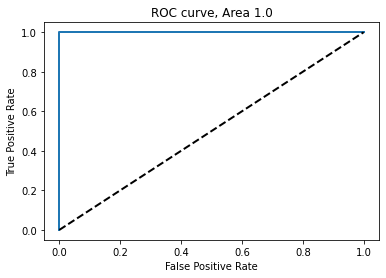

10FCV_confusion_matrix_roc_Lung_KNN_1.png


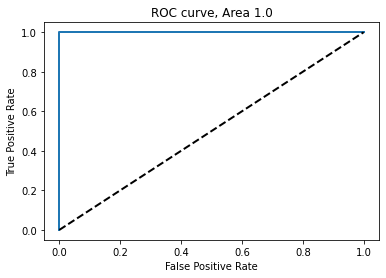

10FCV_confusion_matrix_roc_Lung_Tree_1.png


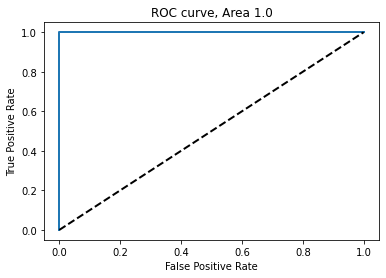

10FCV_confusion_matrix_roc_Lung_SVM_1.png


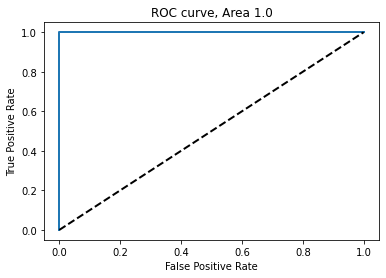

10FCV_confusion_matrix_roc_Lung_NB_2.png


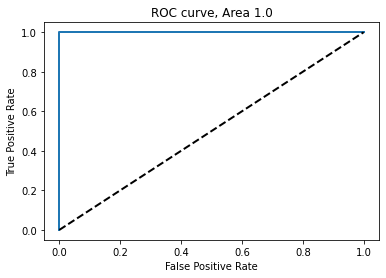

10FCV_confusion_matrix_roc_Lung_KNN_2.png


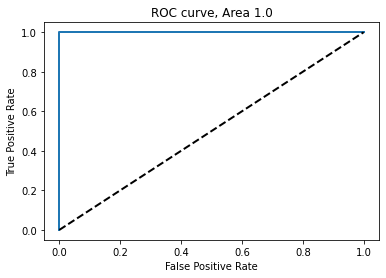

10FCV_confusion_matrix_roc_Lung_Tree_2.png


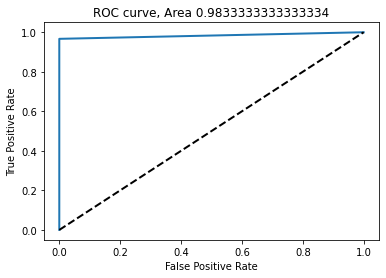

10FCV_confusion_matrix_roc_Lung_SVM_2.png


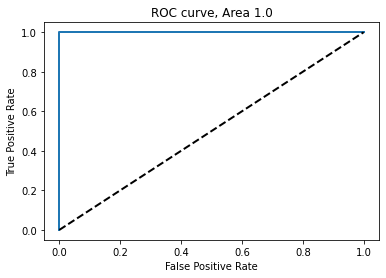

10FCV_confusion_matrix_roc_Lung_NB_3.png


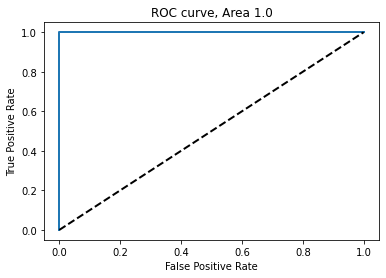

10FCV_confusion_matrix_roc_Lung_KNN_3.png


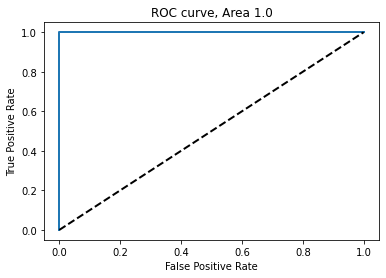

10FCV_confusion_matrix_roc_Lung_Tree_3.png


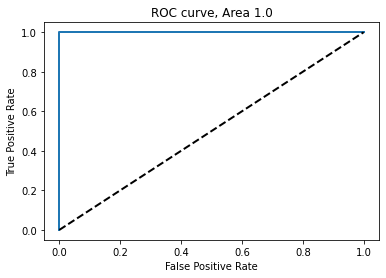

10FCV_confusion_matrix_roc_Lung_SVM_3.png


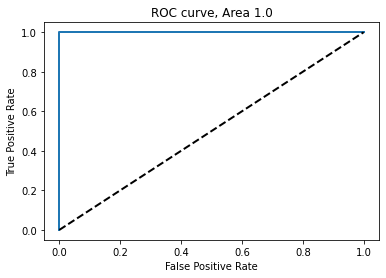

10FCV_confusion_matrix_roc_Lung_NB_4.png


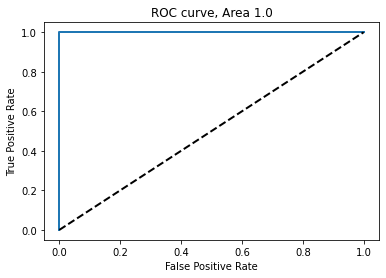

10FCV_confusion_matrix_roc_Lung_KNN_4.png


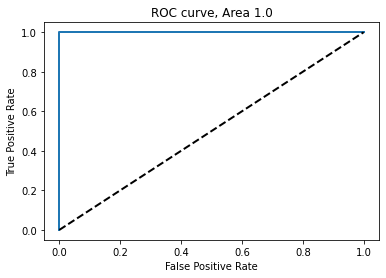

10FCV_confusion_matrix_roc_Lung_Tree_4.png


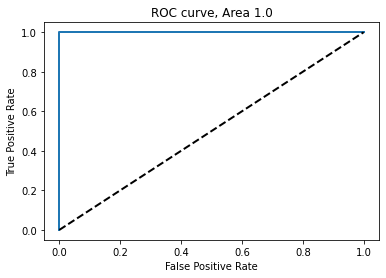

10FCV_confusion_matrix_roc_Lung_SVM_4.png


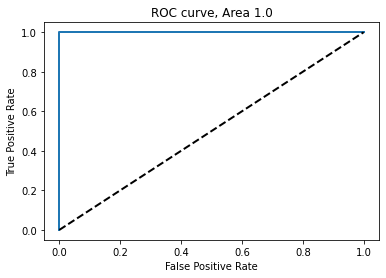

10FCV_confusion_matrix_roc_Lung_NB_5.png


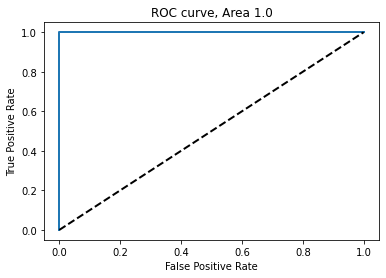

10FCV_confusion_matrix_roc_Lung_KNN_5.png


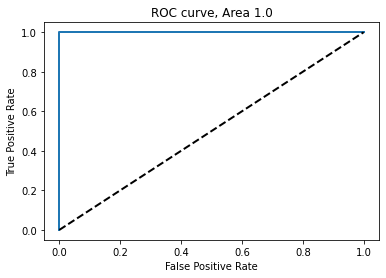

10FCV_confusion_matrix_roc_Lung_Tree_5.png


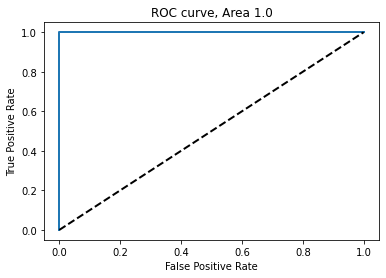

10FCV_confusion_matrix_roc_Lung_SVM_5.png


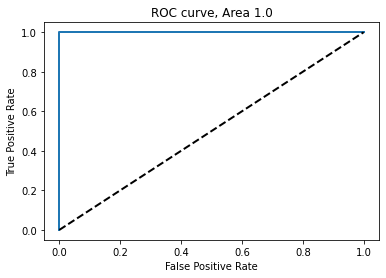

    NB  KNN    Tree  SVM
0  1.0  1.0  1.0000  1.0
1  1.0  1.0  0.9944  1.0
2  1.0  1.0  1.0000  1.0
3  1.0  1.0  1.0000  1.0
4  1.0  1.0  1.0000  1.0


In [73]:
if len(classes) > 2:
  flag = True
else:
  flag = False

acc_df = []
for i in range(1, q+1):  
  #Ensemble of same type classifiers for each filter

  #records the ensemble classifier accuracy of each classifier with i genes
  classifier_accuracy = [] 

  for each_classifier in classifier_dict:
    #creating confusion matrix.
    confusion_matrix = np.zeros(classes.shape[0]**2).reshape(classes.shape[0], classes.shape[0])
    #records the accuracy of the current classifier
    acc=0
    poll_results = []
    actual_labels = []
    for train_index, test_index in kfcv.split(range(rows)):
      """
      Data is divided into train-test splits and then polling method is used 
      to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
      """
      
      filter_result = np.zeros((len(keys_list), len(test_index)))
      # print(filter_result)
      for idx1, filter_name in enumerate(keys_list):

        #taking the train-test split from each filter
        train_data,train_labels = cluster_list[filter_name].iloc[train_index,:i],target[train_index]
        test_data,test_labels = cluster_list[filter_name].iloc[test_index,:i].values,target[test_index].values
        # print("Test Label",test_labels)
        #filter wise fit and predict from the same type of classifier
        classifier_dict[each_classifier].fit(train_data, train_labels)
        for idx2, tst_data in enumerate(test_data):
          # print(idx2,tst_data)
          filter_result[idx1, idx2] = classifier_dict[each_classifier].predict(tst_data.reshape(1,-1))[0]

      #generating the polling result of all filters' classifiers
      for each_col in range(filter_result.shape[1]):

        polling_result = None
        max_freq = 0
        data_col = filter_result[:,each_col]
        for each in set(data_col):
          freq = data_col.tolist().count(each)
          if freq>max_freq:
            max_freq = freq
            polling_result = each
        # print(polling_result)
        poll_results.append(polling_result)
        actual_labels.append(test_labels[each_col])
        confusion_matrix[int(polling_result), int(test_labels[each_col])] += 1
        if polling_result == test_labels[each_col]:
          acc+=1
    
    acc = np.round(acc/rows,4)
    classifier_accuracy.append(acc)
    # print("Confusion Matrix for %s with %s genes:-\n"%(each_classifier, i), confusion_matrix)
    confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
    confusion_matrix.to_csv("10FCV_confusion_matrix_%s_%s_%s.csv"%(DATASET, each_classifier, i))
    if flag:
      plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i, "10FCV")
    else:
      calculate_roc(actual_labels, poll_results, "10FCV_confusion_matrix_roc_%s_%s_%s.png"%(DATASET, each_classifier, i) )

  #records the ensemble classifier accuracy from 1 to q genes for each classifier
  acc_df.append(classifier_accuracy)    
acc_df = pd.DataFrame(acc_df, columns= classifier_dict.keys())
acc_df.to_csv("10FCV-Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
print(acc_df)

In [74]:
!cp 10FCV_confusion_matrix*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/10-Fold/"
!cp 10FCV-Train-EC-Multi-SGC*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/10-Fold/"

## LOOCV


In [ ]:
LOOCV=LeaveOneOut()

LOOCV_confusion_matrix_roc_Breast_NB_1.png


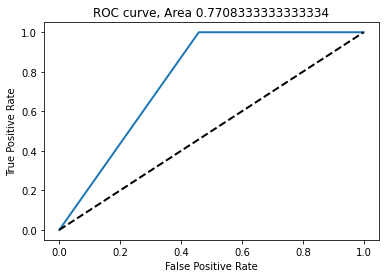

LOOCV_confusion_matrix_roc_Breast_KNN_1.png


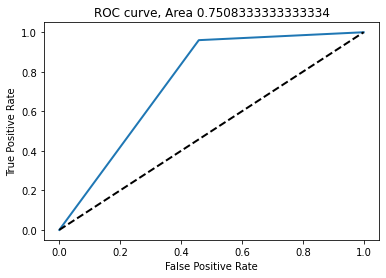

LOOCV_confusion_matrix_roc_Breast_Tree_1.png


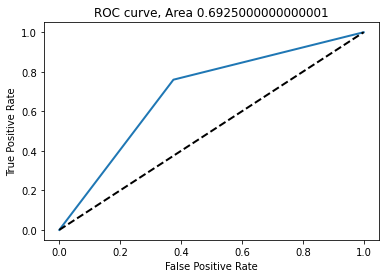

LOOCV_confusion_matrix_roc_Breast_SVM_1.png


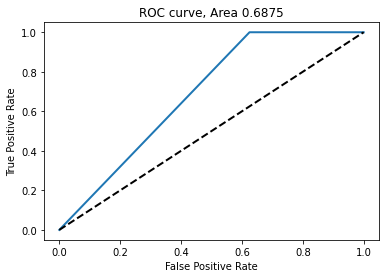

LOOCV_confusion_matrix_roc_Breast_NB_2.png


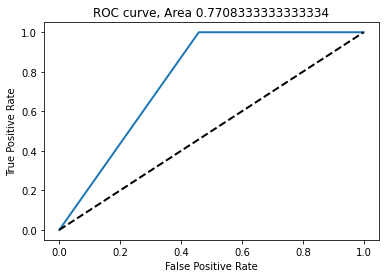

LOOCV_confusion_matrix_roc_Breast_KNN_2.png


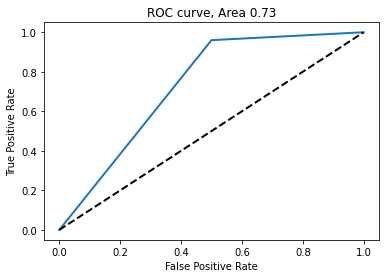

LOOCV_confusion_matrix_roc_Breast_Tree_2.png


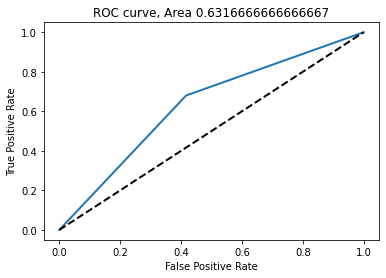

LOOCV_confusion_matrix_roc_Breast_SVM_2.png


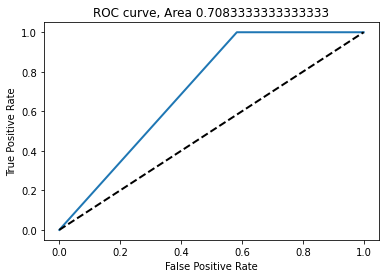

LOOCV_confusion_matrix_roc_Breast_NB_3.png


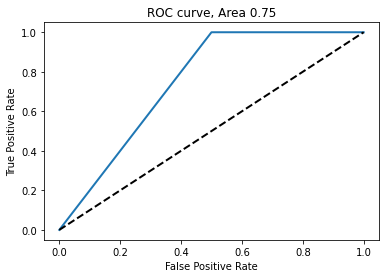

LOOCV_confusion_matrix_roc_Breast_KNN_3.png


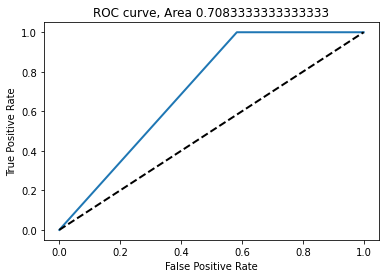

LOOCV_confusion_matrix_roc_Breast_Tree_3.png


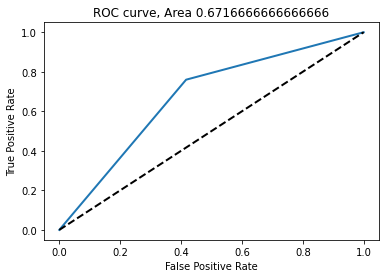

LOOCV_confusion_matrix_roc_Breast_SVM_3.png


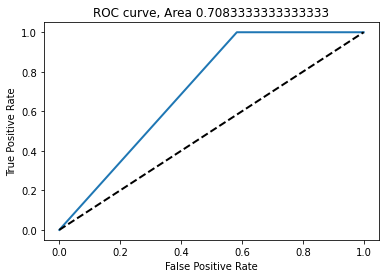

LOOCV_confusion_matrix_roc_Breast_NB_4.png


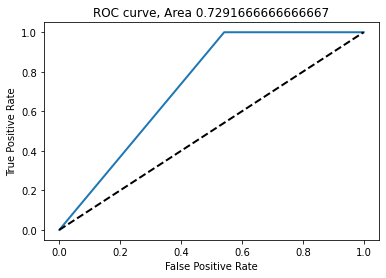

LOOCV_confusion_matrix_roc_Breast_KNN_4.png


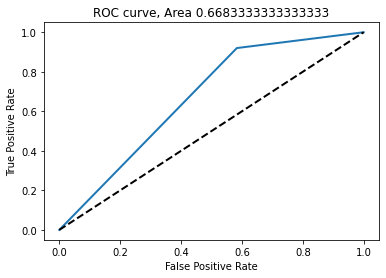

LOOCV_confusion_matrix_roc_Breast_Tree_4.png


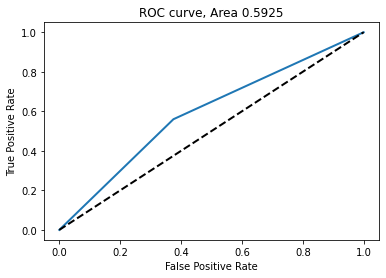

LOOCV_confusion_matrix_roc_Breast_SVM_4.png


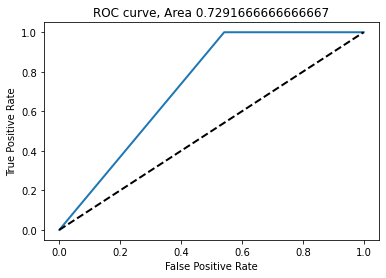

LOOCV_confusion_matrix_roc_Breast_NB_5.png


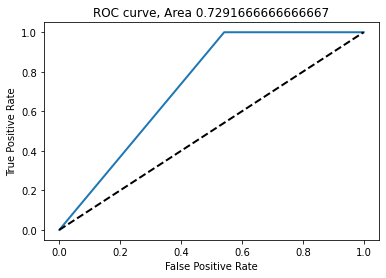

LOOCV_confusion_matrix_roc_Breast_KNN_5.png


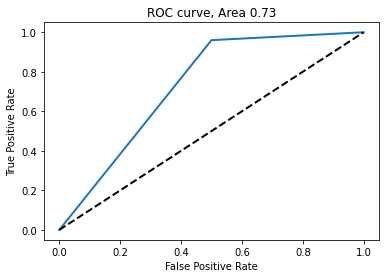

LOOCV_confusion_matrix_roc_Breast_Tree_5.png


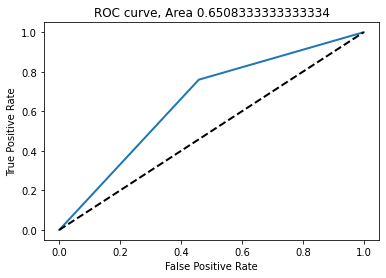

LOOCV_confusion_matrix_roc_Breast_SVM_5.png


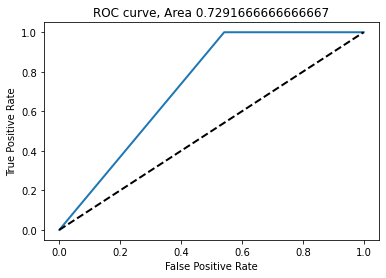

       NB     KNN    Tree     SVM
0  0.7755  0.7551  0.6939  0.6939
1  0.7755  0.7347  0.6327  0.7143
2  0.7551  0.7143  0.6735  0.7143
3  0.7347  0.6735  0.5918  0.7347
4  0.7347  0.7347  0.6531  0.7347


In [ ]:
acc_df = []
if len(classes) > 2:
  flag = True
else:
  flag = False

for i in range(1, q+1):  
  #Ensemble of same type classifiers for each filter

  #records the ensemble classifier accuracy of each classifier with i genes
  classifier_accuracy = [] 

  for each_classifier in classifier_dict:
    #creating confusion matrix.
    confusion_matrix = np.zeros(classes.shape[0]**2).reshape(classes.shape[0], classes.shape[0])
    # print(confusion_matrix)
    #records the accuracy of the current classifier
    acc=0
    poll_results = []
    actual_labels = []
    for train_index, test_index in LOOCV.split(range(rows)):
      """
      Data is divided into train-test splits and then polling method is used 
      to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
      """
      
      filter_result = []
      for filter_name in keys_list:

        #taking the train-test split from each filter
        train_data,train_labels = cluster_list[filter_name].iloc[train_index,:i],target[train_index]
        test_data,test_labels = cluster_list[filter_name].iloc[test_index,:i],target[test_index].values.tolist()[0]

        #filter wise fit and predict from the same type of classifier
        classifier_dict[each_classifier].fit(train_data, train_labels)
        filter_result.append(classifier_dict[each_classifier].predict(test_data)[0])

      #generating the polling result of all filters' classifiers
      polling_result = None
      max_freq = 0
      for each in set(filter_result):
        freq = filter_result.count(each)
        if freq>max_freq:
          max_freq = freq
          polling_result = each
      # print(polling_result, test_labels)
      poll_results.append(polling_result)
      actual_labels.append(test_labels)
      confusion_matrix[int(polling_result), int(test_labels)] += 1
      if polling_result == test_labels:
        acc+=1
    
    acc = np.round(acc/rows,4)
    classifier_accuracy.append(acc)
    # print("Confusion Matrix for %s with %s genes:-\n"%(each_classifier, i), confusion_matrix)
    confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
    confusion_matrix.to_csv("LOOCV_confusion_matrix_%s_%s_%s.csv"%(DATASET, each_classifier, i))
    if flag:
      plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i)
    else:
      calculate_roc(actual_labels, poll_results, "LOOCV_confusion_matrix_roc_%s_%s_%s.png"%(DATASET, each_classifier, i) )

  #records the ensemble classifier accuracy from 1 to q genes for each classifier
  acc_df.append(classifier_accuracy)    
acc_df = pd.DataFrame(acc_df, columns= classifier_dict.keys())
acc_df.to_csv("LOOCV-Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
print(acc_df)

## 5 Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

kfcv = KFold(5, True, random_state = 0)

5FCV_confusion_matrix_roc_Breast_NB_1.png


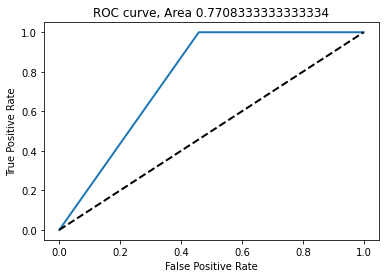

5FCV_confusion_matrix_roc_Breast_KNN_1.png


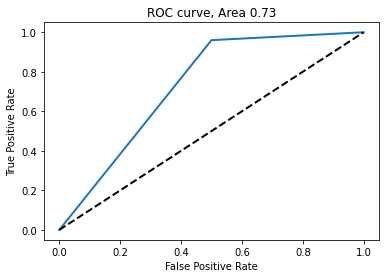

5FCV_confusion_matrix_roc_Breast_Tree_1.png


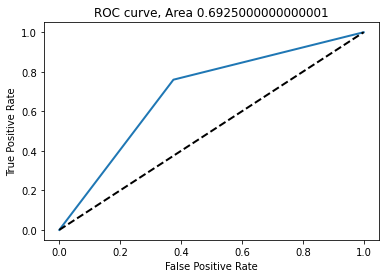

5FCV_confusion_matrix_roc_Breast_SVM_1.png


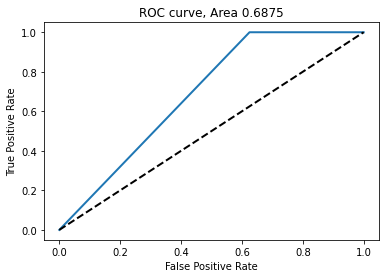

5FCV_confusion_matrix_roc_Breast_NB_2.png


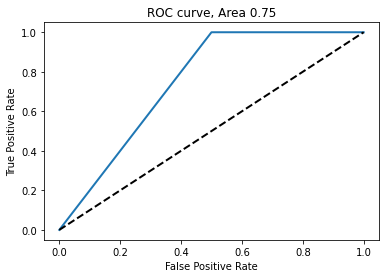

5FCV_confusion_matrix_roc_Breast_KNN_2.png


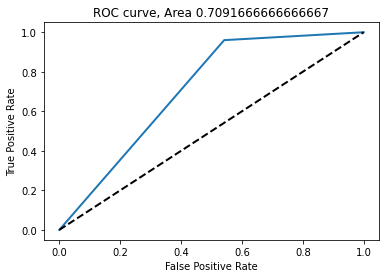

5FCV_confusion_matrix_roc_Breast_Tree_2.png


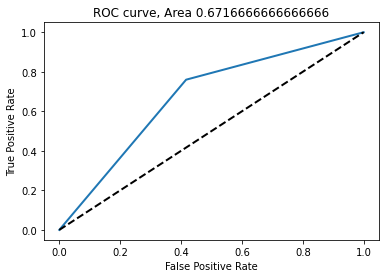

5FCV_confusion_matrix_roc_Breast_SVM_2.png


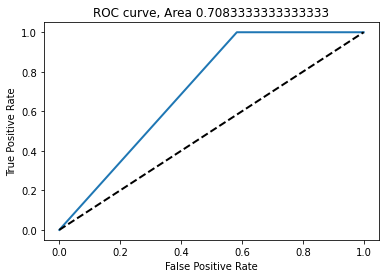

5FCV_confusion_matrix_roc_Breast_NB_3.png


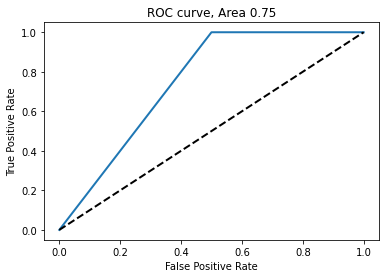

5FCV_confusion_matrix_roc_Breast_KNN_3.png


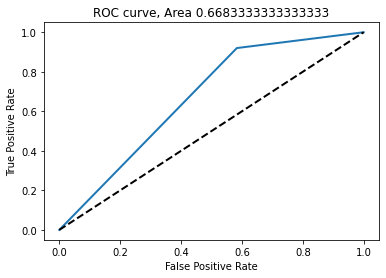

5FCV_confusion_matrix_roc_Breast_Tree_3.png


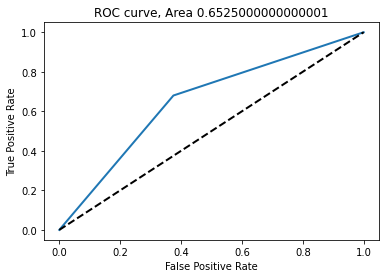

5FCV_confusion_matrix_roc_Breast_SVM_3.png


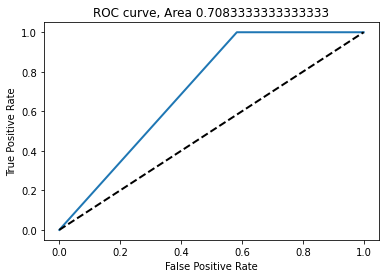

5FCV_confusion_matrix_roc_Breast_NB_4.png


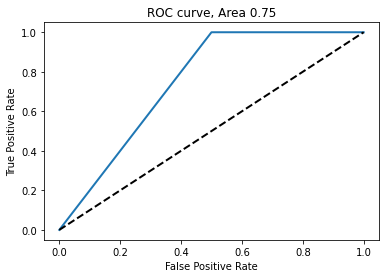

5FCV_confusion_matrix_roc_Breast_KNN_4.png


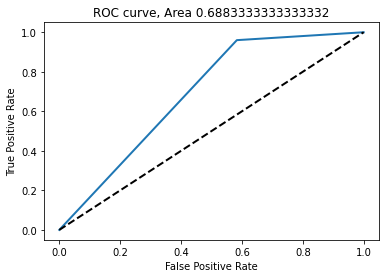

5FCV_confusion_matrix_roc_Breast_Tree_4.png


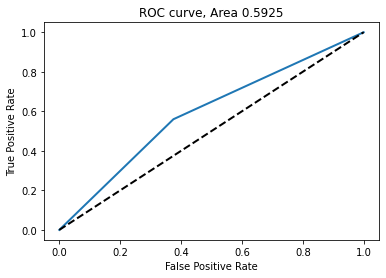

5FCV_confusion_matrix_roc_Breast_SVM_4.png


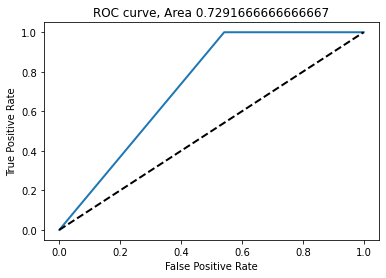

5FCV_confusion_matrix_roc_Breast_NB_5.png


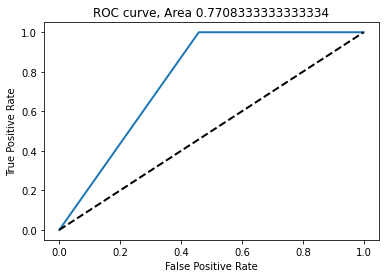

5FCV_confusion_matrix_roc_Breast_KNN_5.png


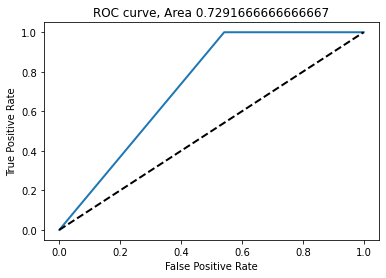

5FCV_confusion_matrix_roc_Breast_Tree_5.png


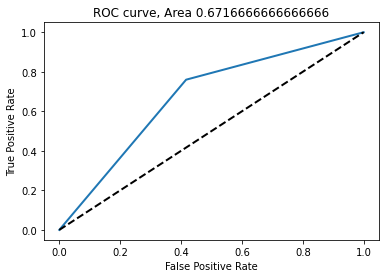

5FCV_confusion_matrix_roc_Breast_SVM_5.png


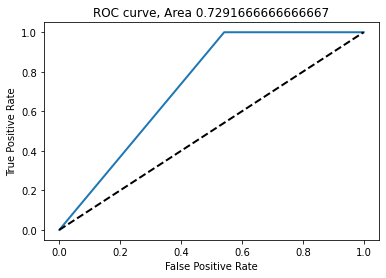

       NB     KNN    Tree     SVM
0  0.7755  0.7347  0.6939  0.6939
1  0.7551  0.7143  0.6735  0.7143
2  0.7551  0.6735  0.6531  0.7143
3  0.7551  0.6939  0.5918  0.7347
4  0.7755  0.7347  0.6735  0.7347


In [ ]:
acc_df = []
for i in range(1, q+1):  
  #Ensemble of same type classifiers for each filter

  #records the ensemble classifier accuracy of each classifier with i genes
  classifier_accuracy = [] 

  for each_classifier in classifier_dict:
    #creating confusion matrix.
    confusion_matrix = np.zeros(classes.shape[0]**2).reshape(classes.shape[0], classes.shape[0])
    #records the accuracy of the current classifier
    acc=0
    poll_results = []
    actual_labels = []
    for train_index, test_index in kfcv.split(range(rows)):
      """
      Data is divided into train-test splits and then polling method is used 
      to find the classification results (ensemble of KNN,SVM,NB,Decision Tree)
      """
      
      filter_result = np.zeros((len(keys_list), len(test_index)))
      # print(filter_result)
      for idx1, filter_name in enumerate(keys_list):

        #taking the train-test split from each filter
        train_data,train_labels = cluster_list[filter_name].iloc[train_index,:i],target[train_index]
        test_data,test_labels = cluster_list[filter_name].iloc[test_index,:i].values,target[test_index].values
        # print("Test Label",test_labels)
        #filter wise fit and predict from the same type of classifier
        classifier_dict[each_classifier].fit(train_data, train_labels)
        for idx2, tst_data in enumerate(test_data):
          # print(idx2,tst_data)
          filter_result[idx1, idx2] = classifier_dict[each_classifier].predict(tst_data.reshape(1,-1))[0]

      #generating the polling result of all filters' classifiers
      for each_col in range(filter_result.shape[1]):

        polling_result = None
        max_freq = 0
        data_col = filter_result[:,each_col]
        for each in set(data_col):
          freq = data_col.tolist().count(each)
          if freq>max_freq:
            max_freq = freq
            polling_result = each
        # print(polling_result)
        poll_results.append(polling_result)
        actual_labels.append(test_labels[each_col])
        confusion_matrix[int(polling_result), int(test_labels[each_col])] += 1
        if polling_result == test_labels[each_col]:
          acc+=1
    
    acc = np.round(acc/rows,4)
    classifier_accuracy.append(acc)
    # print("Confusion Matrix for %s with %s genes:-\n"%(each_classifier, i), confusion_matrix)
    confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
    confusion_matrix.to_csv("5FCV_confusion_matrix_%s_%s_%s.csv"%(DATASET, each_classifier, i))
    if flag:
      plot_confusion_matrix(confusion_matrix, DATASET, each_classifier, i, "5FCV")
    else:
      calculate_roc(actual_labels, poll_results, "5FCV_confusion_matrix_roc_%s_%s_%s.png"%(DATASET, each_classifier, i) )

  #records the ensemble classifier accuracy from 1 to q genes for each classifier
  acc_df.append(classifier_accuracy)    
acc_df = pd.DataFrame(acc_df, columns= classifier_dict.keys())
acc_df.to_csv("5FCV-Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
print(acc_df)

## Copying Results and Confusion Matrix to Google Drive

In [ ]:
!cp LOOCV_confusion_matrix*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/LOOCV/"
!cp LOOCV-Train-EC-Multi-SGC*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/LOOCV/"
!cp 5FCV_confusion_matrix*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/5-Fold/"
!cp 5FCV-Train-EC-Multi-SGC*.* "/content/drive/My Drive/For Sir and Ma'am/MFSGC Results/Confusion Matrix/5-Fold/"


## Downloading the Files
Downloads all the Files generated for this dataset. Please note: The dataset name must be specified in the DATASET 
variable before proceeding with the steps below.

Incase of 'failed to fetch' error, please rerun these cell.

In [ ]:
#Download the MFSGC and MFSGC-EC Results
files.download("LOOCV-Train-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))
files.download("5FCV-Train-EC-Multi-SGC-%s_p%s_q%s_Accuracy_Matrix.csv"%(DATASET, p, q))

In [ ]:
#Downloading the Cluster Formation Sequence
for x in ['mi','chi','relief', 'pc', 'fs', 'tt', 'snr']:
  files.download("%s_p%s_q%s%s_cluster.json"%(DATASET, p, q, x))

In [ ]:
#Download Representative Genes Formed
for x in range(1,8):
  files.download("%s_p%s_q%sRepresentative_Genes_%d.csv"%(DATASET, p, q, x))

In [ ]:
#*****************-----Notebook Training Code Ends Here. Below are cells for loading pre-calculated values for Representative Genes and Cluster Sequences.-------*****************************

In [ ]:
#Cell Left Empty Intentionally.

## Loading Gene Representatives and Clusters
The below cells can be run to load gene representatives and clusters if you already have them prepared.

In [ ]:
"""
Loading the Cluster JSON files from memory
"""

with open('%s_p%s_q%smi_cluster.json'%(DATASET, p, q), 'r') as fp:
  mi_cluster=json.load(fp)

with open('%s_p%s_q%srelief_cluster.json'%(DATASET, p, q), 'r') as fp:
  chi_cluster=json.load(fp)


with open('%s_p%s_q%schi_cluster.json'%(DATASET, p, q), 'r') as fp:
  relief_cluster=json.load(fp)

with open('%s_p%s_q%spc_cluster.json'%(DATASET, p, q), 'r') as fp:
  pc_cluster=json.load(fp)

with open('%s_p%s_q%sfs_cluster.json'%(DATASET, p, q), 'r') as fp:
  fs_cluster=json.load(fp)

with open('%s_p%s_q%stt_cluster.json'%(DATASET, p, q), 'r') as fp:
  tt_cluster=json.load(fp)

with open('%s_p%s_q%ssnr_cluster.json'%(DATASET, p, q), 'r') as fp:
  snr_cluster=json.load(fp)